In [1]:
import time
from pathlib import Path

CUR_ABS_DIR = Path.cwd().resolve()
PROJ_DIR = (CUR_ABS_DIR / '../../../').resolve()
print(PROJ_DIR)

ISSUE_TAG = "\033[91m[issue]\033[0m "  # Red
INFO_TAG = "\033[94m[info]\033[0m "  # Blue
SUCCESS_TAG = "\033[92m[success]\033[0m "  # Green

/mnt/832acd65-7396-480e-aa76-dca6765861b0/research-repo/projects/2025.09_hydrology_Switzerland/codes/swiss-river-network-benchmark


In [2]:
# # Magic home
# %cd /home/benjamin/git/swiss-river-network/

import numpy as np
import matplotlib.pyplot as plt

from swissrivernetwork.benchmark.dataset import read_graph, read_csv_test, read_csv_train, read_stations, \
    select_isolated_station
from swissrivernetwork.util.datetime import to_human, from_unix_days

# Labels
label = {}
label['swiss-1990'] = 'Swiss 1990'
label['swiss-2010'] = 'Swiss 2010'
label['zurich'] = 'Zurich'

# Variables
GRAPH_NAMES = ['swiss-1990', 'swiss-2010', 'zurich']


def print_dates(df):
    vmin, vmax = df['epoch_day'].min(), df['epoch_day'].max()
    print('Training:', to_human(from_unix_days(vmin)), to_human(from_unix_days(vmax)))


for graph_name in GRAPH_NAMES:
    # Load Graph Data:
    g, e = read_graph(graph_name, base_dir=PROJ_DIR)
    n = g.shape[0]

    # compute covered area:
    dx = g[:, 0].max() - g[:, 0].min()
    dy = g[:, 1].max() - g[:, 1].min()
    dx, dy = dx / 1000, dy / 1000  # in km
    area = dx * dy
    area_per_n = area / n

    # print table values:
    print(f'~~~ {label[graph_name]} ~~~ ')
    print('Stations:', n)
    print('Density:', area_per_n)

    # Get the years
    df = read_csv_train(graph_name, base_dir=PROJ_DIR)
    print_dates(df)
    df = read_csv_test(graph_name, base_dir=PROJ_DIR)
    print_dates(df)

~~~ Swiss 1990 ~~~ 
Stations: 28
Density: tensor(1596.2872)
Training: 1990-01-02 00:00:00+00:00 2012-12-31 00:00:00+00:00
Training: 2013-01-02 00:00:00+00:00 2020-12-31 00:00:00+00:00
~~~ Swiss 2010 ~~~ 
Stations: 63
Density: tensor(1039.8373)
Training: 2005-01-02 00:00:00+00:00 2017-12-31 00:00:00+00:00
Training: 2018-01-01 00:00:00+00:00 2020-12-31 00:00:00+00:00
~~~ Zurich ~~~ 
Stations: 15
Density: tensor(73.8142)
Training: 2009-01-01 00:00:00+00:00 2019-12-31 00:00:00+00:00
Training: 2020-01-01 00:00:00+00:00 2022-10-31 00:00:00+00:00


In [3]:
# Check the gaps between subsequences:

def plot_gaps(epoch_days, y=None, title='Sequence Gaps'):
    plt.figure(figsize=(20, 6))
    if y is not None:
        raise NotImplementedError('Not implemented yet for y != None')

    # Plot sequence separators as vertical dashed lines:
    day_diff = np.diff(epoch_days)
    breaks = day_diff != 1
    breaks = np.concatenate((np.array([True]), breaks))
    seque_id = np.cumsum(breaks)
    seques = np.argwhere(breaks).flatten()
    unique_ids, counts = np.unique(seque_id, return_counts=True)
    seque_lengths = counts
    starts = epoch_days[seques]
    ends = epoch_days[seques + seque_lengths - 1]
    colors = plt.get_cmap('tab20', len(starts))
    fill_params = []
    for i, (s, e) in enumerate(zip(starts, ends)):
        plt.axvline(x=s, color=colors(i), linestyle='--', alpha=0.5, linewidth=0.5)
        plt.axvline(x=e, color=colors(i), linestyle='--', alpha=0.5, linewidth=0.5)
        fill_params.append({'s': s, 'e': e, 'color': colors(i), 'ylim': plt.ylim()})
        plt.text(
            (s + e) / 2, plt.ylim()[1] * 0.25, f'Seq: {e - s + 1} days', color='orange', fontsize=10,
            horizontalalignment='center', verticalalignment='center',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='grey'), rotation=90,
        )
    # Annotate the length of each gap:
    for i in range(len(starts) - 1):
        gap = starts[i + 1] - ends[i]
        if gap >= 1:
            plt.text(
                (ends[i] + starts[i + 1]) / 2, plt.ylim()[1] * 0.75,
                f'Gap: {gap - 1} days', color='white', fontsize=10,
                horizontalalignment='center', verticalalignment='center',
                bbox=dict(facecolor='grey', alpha=0.8, edgecolor='grey'), rotation=90,
            )

    max_ylim = (min([p['ylim'][0] for p in fill_params]), max([p['ylim'][1] for p in fill_params]))
    for param in fill_params:
        plt.fill_betweenx(max_ylim, param['s'], param['e'], color=param['color'], alpha=0.1)
    if y is not None:
        plt.legend()
    plt.title(title.replace('\t', ' '))
    # fig_path = Path(dump_dir) / f'figures/{graph_name}_{method}_difference.png'
    # os.makedirs(fig_path.parent, exist_ok=True)
    # plt.savefig(fig_path, dpi=300)
    plt.show()
    plt.close()

In [11]:
def get_missing_temperature_days(df, stations):
    missing_days = {}
    epoch_days = df['epoch_day']
    stations = sorted(stations)
    for station in stations:
        df_station = select_isolated_station(df, station)
        # print(df_station)
        # print(df_station['water_temperature'])
        # print(df_station['water_temperature'].isna())
        # print(np.where(df_station['water_temperature'].isna())[0])
        # print(np.where(df_station['air_temperature'].isna())[0])
        idx_missing = np.concatenate(
            (np.where(df_station['water_temperature'].isna())[0], np.where(df_station['air_temperature'].isna())[0]),
            axis=0
        )
        # idx_missing = np.where(df_station['air_temperature'].isna())[0]
        days_missing = df_station.iloc[idx_missing]['epoch_day'].to_numpy()
        days_missing = np.sort(np.unique(days_missing))
        # print(days_missing)
        # print(f'idx_missing: {idx_missing}')
        # print(idx_missing.size)
        # if idx_missing.size != 0:
        #     print(f'{station} missing days !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        missing_days[station] = days_missing
        # print(f'Station {station} missing days: {missing_days[station]}')
    print(f'{ISSUE_TAG}# of days with missing temperatures per station:', {k: len(v) for k, v in missing_days.items() if len(v) > 0})
    return missing_days


def plot_missing_temperature_days(missing_days, title='Missing Days per Station'):
    num_stations = len(missing_days)
    seques_more_than_one = {}

    extra_height = 0.2
    height = num_stations / 5 + extra_height
    plt.figure(figsize=(20, height))
    ylim = (0, num_stations + 1)
    plt.ylim(ylim)
    plt.yticks(ticks=np.arange(1, num_stations + 1), labels=list(missing_days.keys()))
    plt.ylabel('stations')
    plt.xlabel('days')
    plt.title(title)
    plt.grid(axis='both', linestyle='--', alpha=0.5)

    for idx, (station, days) in enumerate(missing_days.items()):
        seques_more_than_one[station] = []

        if len(days) == 0:
            continue

        day_diff = np.diff(days)
        breaks = day_diff != 1
        breaks = np.concatenate((np.array([True]), breaks))
        seque_id = np.cumsum(breaks)
        seques = np.argwhere(breaks).flatten()
        unique_ids, counts = np.unique(seque_id, return_counts=True)
        seque_lengths = counts
        starts = days[seques]
        ends = days[seques + seque_lengths - 1]
        for s, e in zip(starts, ends):
            if e - s >= 1:
                color = 'tab:red'
                text_color = 'red'
                width = 0.8
                extra_text = f': {e - s + 1} days'
                seques_more_than_one[station].append(e - s + 1)
            else:
                color = 'tab:blue'
                text_color = 'black'
                width = 0.4
                extra_text = ''
            cur_ylim = (idx + 1 - width, idx + 1 + width)
            plt.fill_betweenx(cur_ylim, s, e, color=color, alpha=0.5)
            if s == e:
                plt.text(
                    s, idx + 1.1, f'{s}{extra_text}', color=text_color, fontsize=7,
                    horizontalalignment='center', verticalalignment='center',
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='grey'),
                )
            else:
                plt.text(
                    (s + e) / 2, idx + 1.1, f'{s} - {e}{extra_text}', color=text_color, fontsize=7,
                    horizontalalignment='center', verticalalignment='center',
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='grey'),
                )
    plt.subplots_adjust(bottom=extra_height / height)

    plt.figtext(
        0.1, -0.05,
        f'# of sequences of days with missing temperatures more than 1 day: ' + str(
            {k: len(v) for k, v in seques_more_than_one.items() if len(v) > 0}
        )
    )

    plt.show()
    print(
        f'{ISSUE_TAG}# of sequences of days with missing temperatures per station (more than 1 day):',
        {k: len(v) for k, v in seques_more_than_one.items() if len(v) > 0}
    )

~~~ Swiss 1990 ~~~ 
[info] Stations: 28
['2091', '2143', '2016', '2018', '2243', '2415', '2044', '2473', '2029', '2634', '2152', '2104', '2085', '2034', '2481', '2056', '2084', '2372', '2500', '2135', '2070', '2030', '2109', '2019', '2174', '2170', '2009', '2269']
[info] Training Samples: 7920.
[info] min day: 7306, max day: 15705.
[issue] Gaps: [  2   2   2   2   2  91   2  13 373]


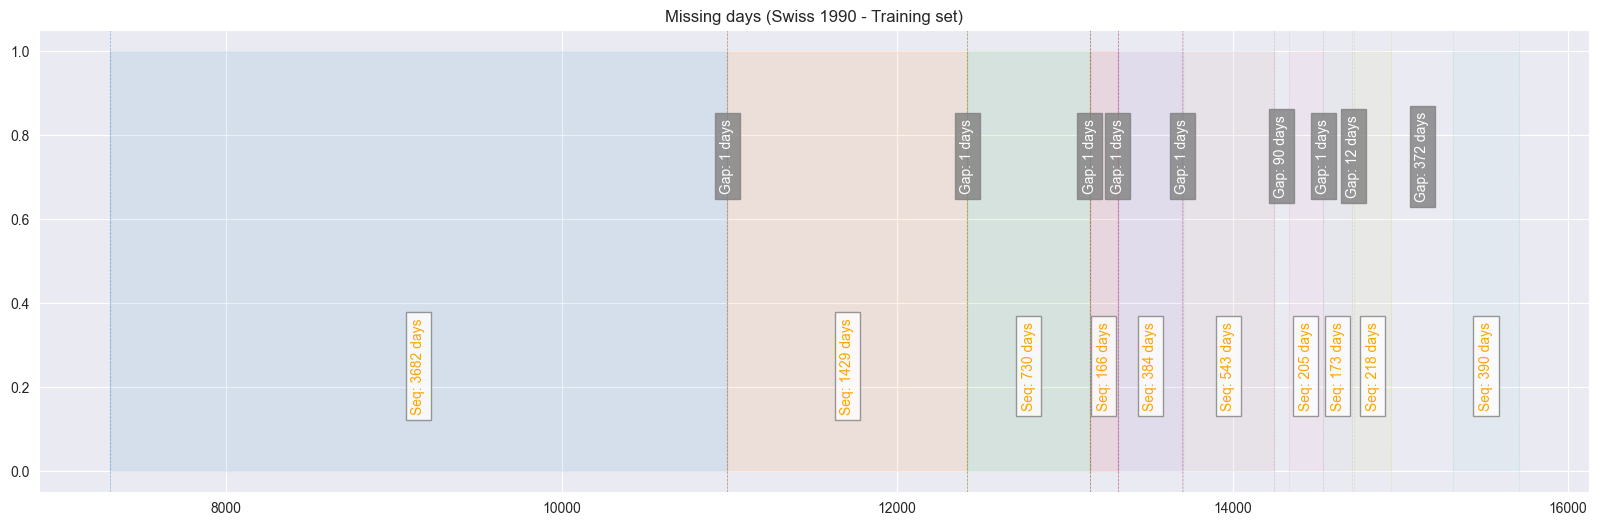

[issue] # of days with missing temperatures per station: {}


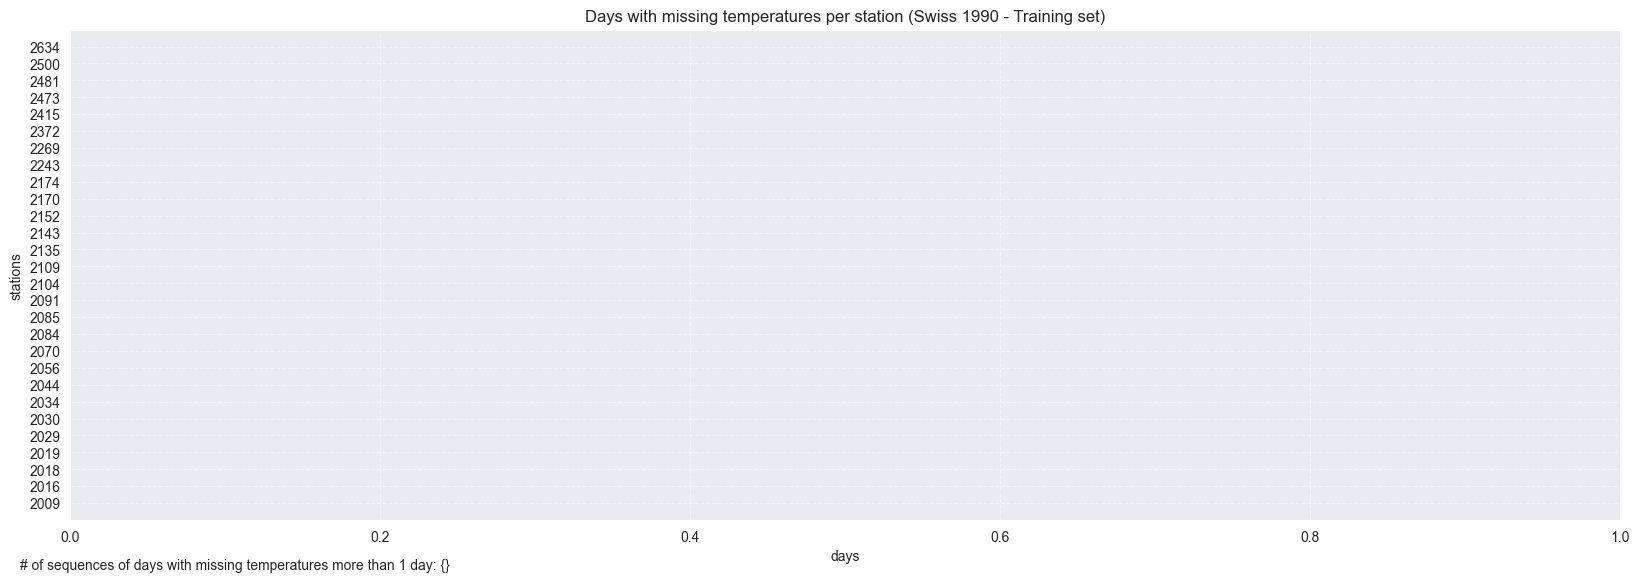

[issue] # of sequences of days with missing temperatures per station (more than 1 day): {}

[info] Test Samples: 2188.
[info] min day: 15707, max day: 18627.
[issue] Test Gaps: [  2   2   2 731]


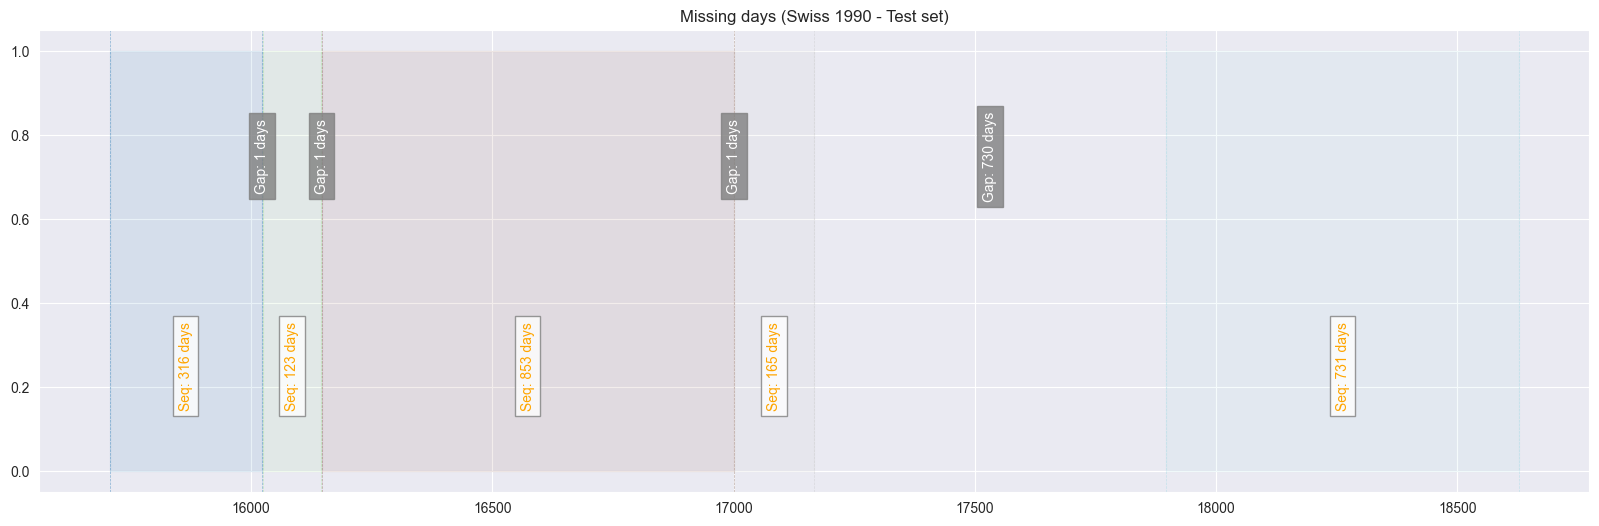

[issue] # of days with missing temperatures per station: {}


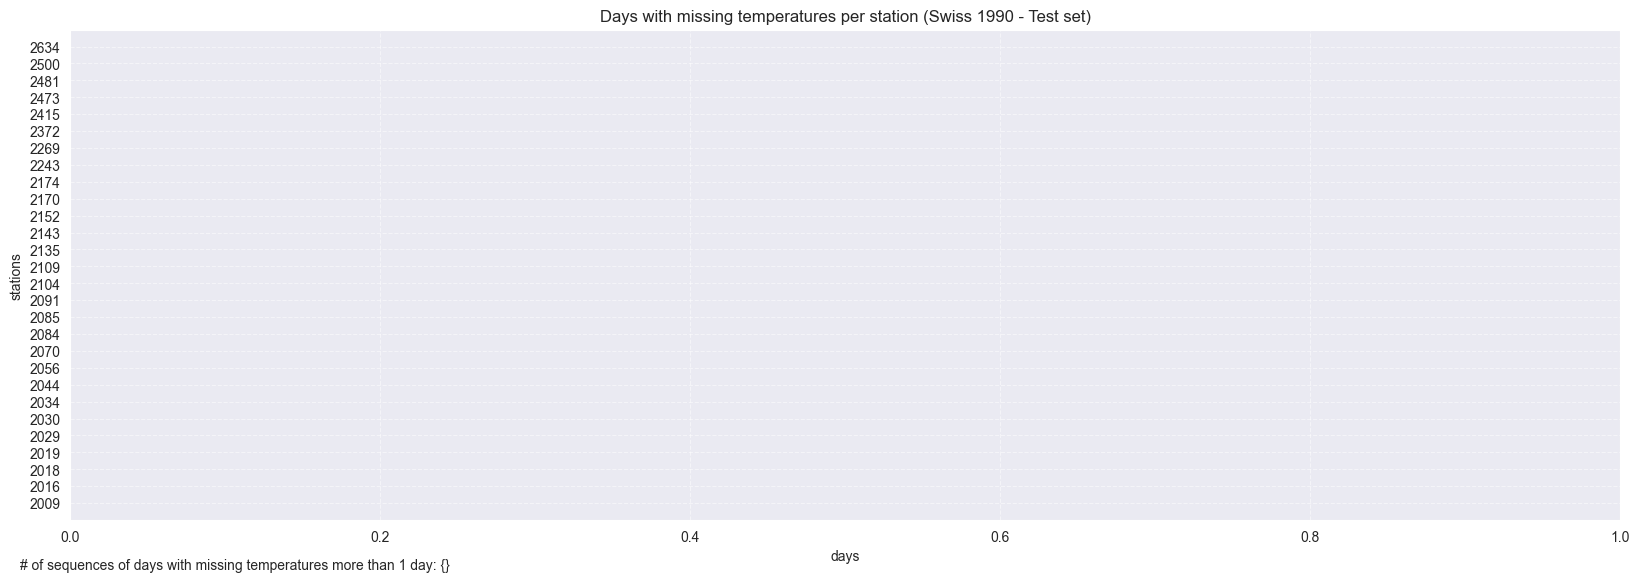

[issue] # of sequences of days with missing temperatures per station (more than 1 day): {}
~~~ Swiss 2010 ~~~ 
[info] Stations: 63
['2091', '2143', '2016', '2018', '2243', '2415', '2044', '2288', '2608', '2343', '2029', '2634', '2152', '2604', '2609', '2635', '2104', '2386', '2414', '2374', '2112', '2308', '2410', '2150', '2033', '2327', '2473', '2307', '2085', '2034', '2369', '2084', '2056', '2276', '2481', '2372', '2126', '2467', '2500', '2135', '2179', '2070', '2282', '2159', '2030', '2457', '2232', '2109', '2019', '2174', '2606', '2170', '2009', '2432', '2351', '2269', '2167', '2068', '2612', '2347', '2462', '2617', '2256']
[info] Training Samples: 4747.
[info] min day: 12785, max day: 17531.
[issue] Gaps: []


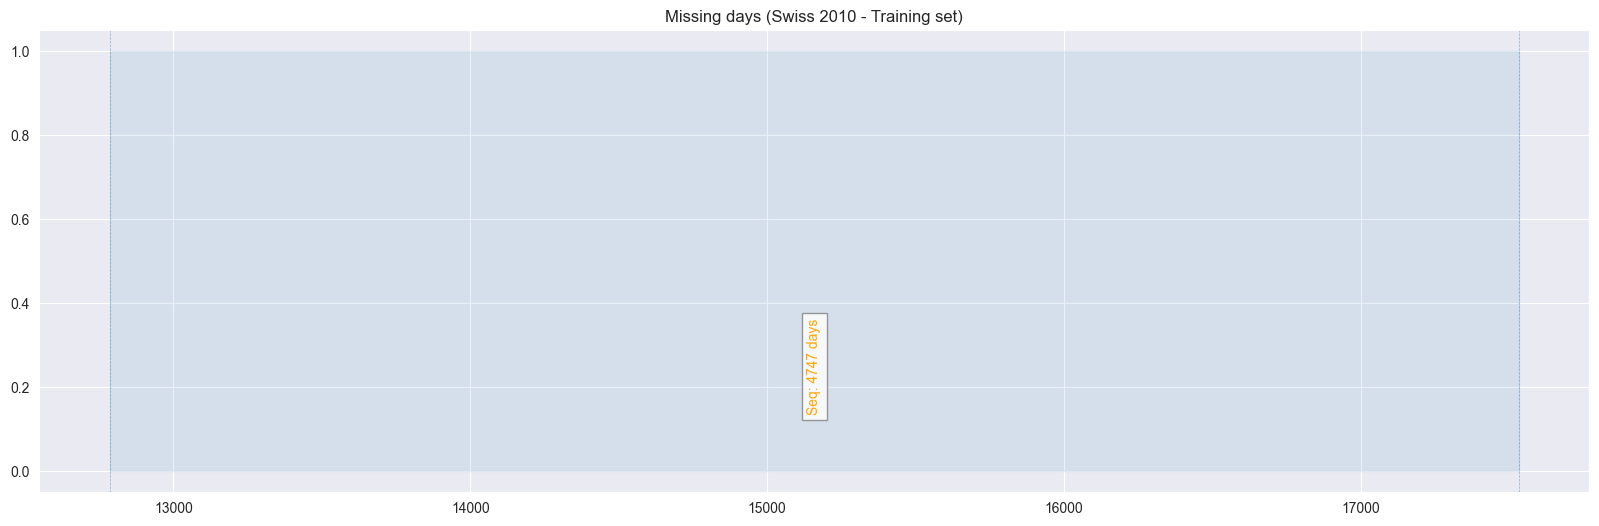

[issue] # of days with missing temperatures per station: {'2085': 1, '2091': 134, '2104': 2, '2109': 2, '2112': 364, '2126': 2, '2159': 731, '2179': 2, '2243': 2, '2288': 1463, '2374': 731, '2386': 729, '2432': 2, '2467': 2, '2481': 10, '2609': 364, '2634': 369, '2635': 1}


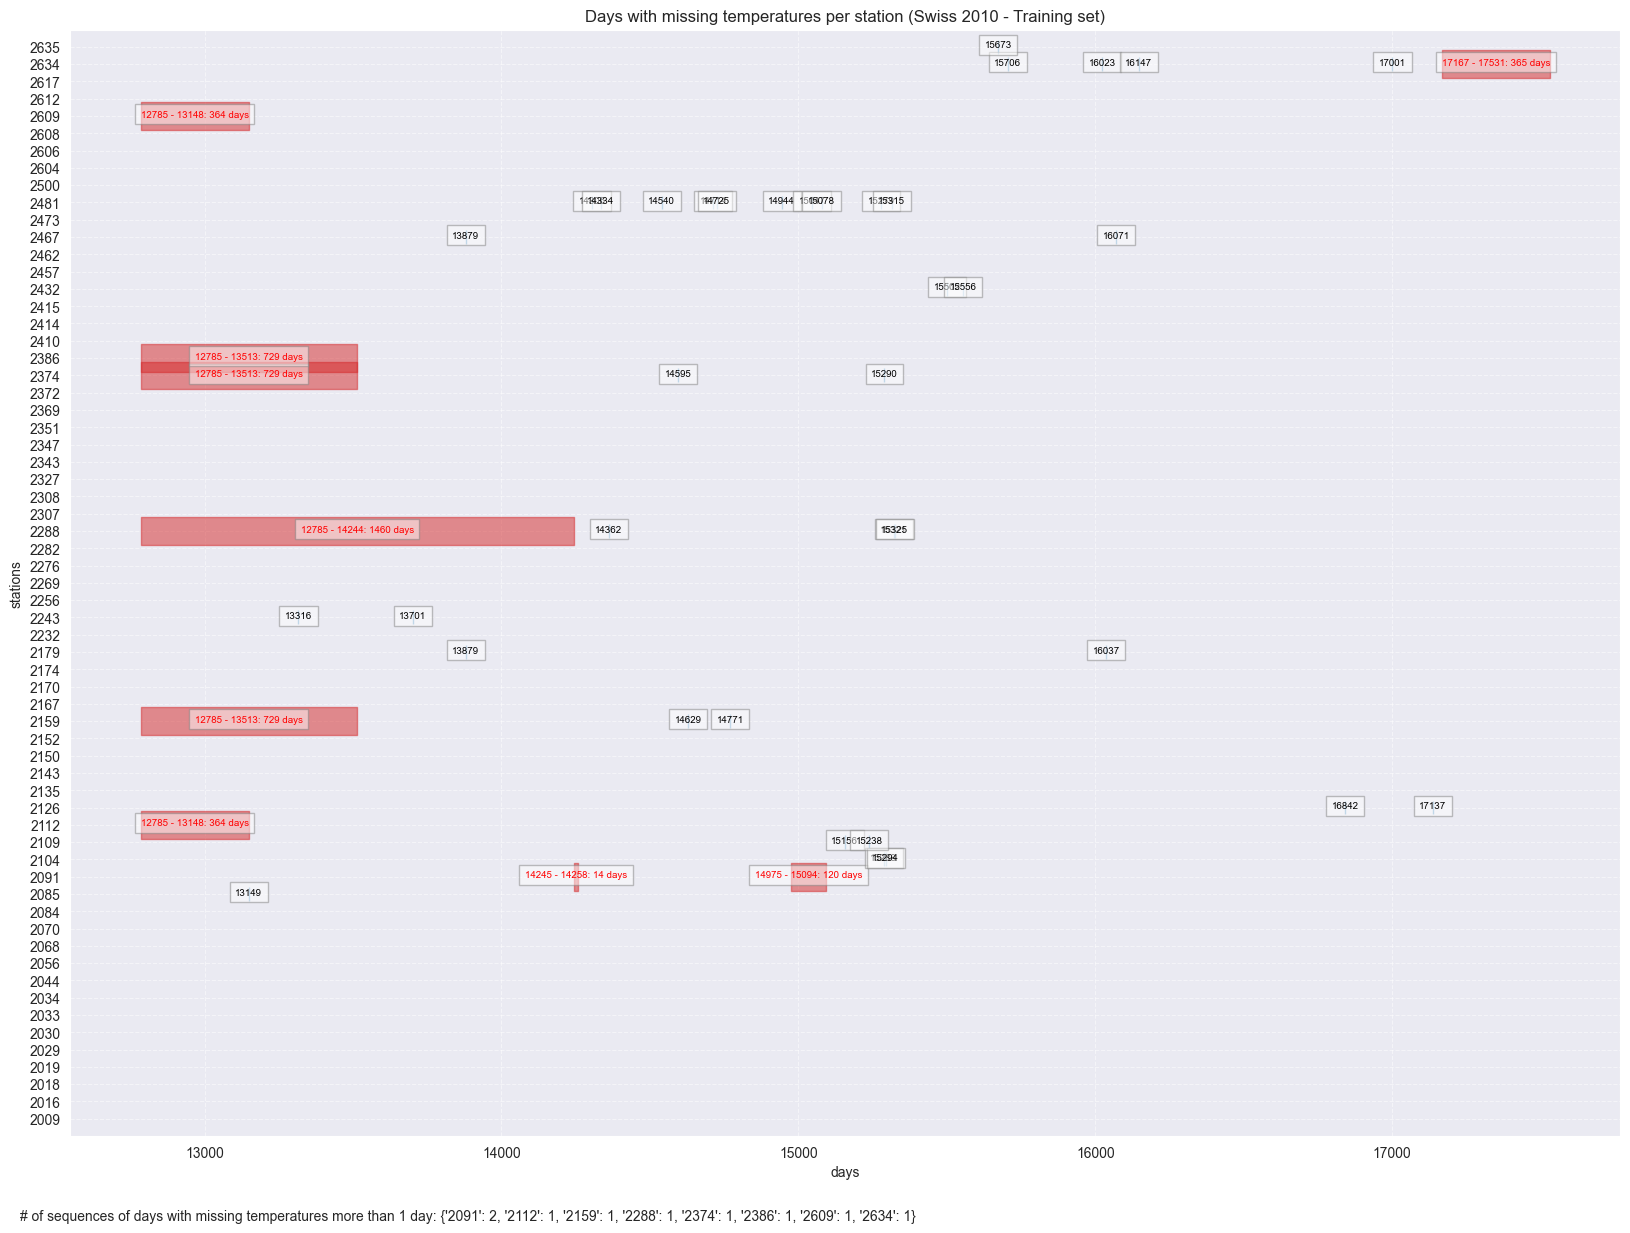

[issue] # of sequences of days with missing temperatures per station (more than 1 day): {'2091': 2, '2112': 1, '2159': 1, '2288': 1, '2374': 1, '2386': 1, '2609': 1, '2634': 1}

[info] Test Samples: 1096.
[info] min day: 17532, max day: 18627.
[issue] Test Gaps: []


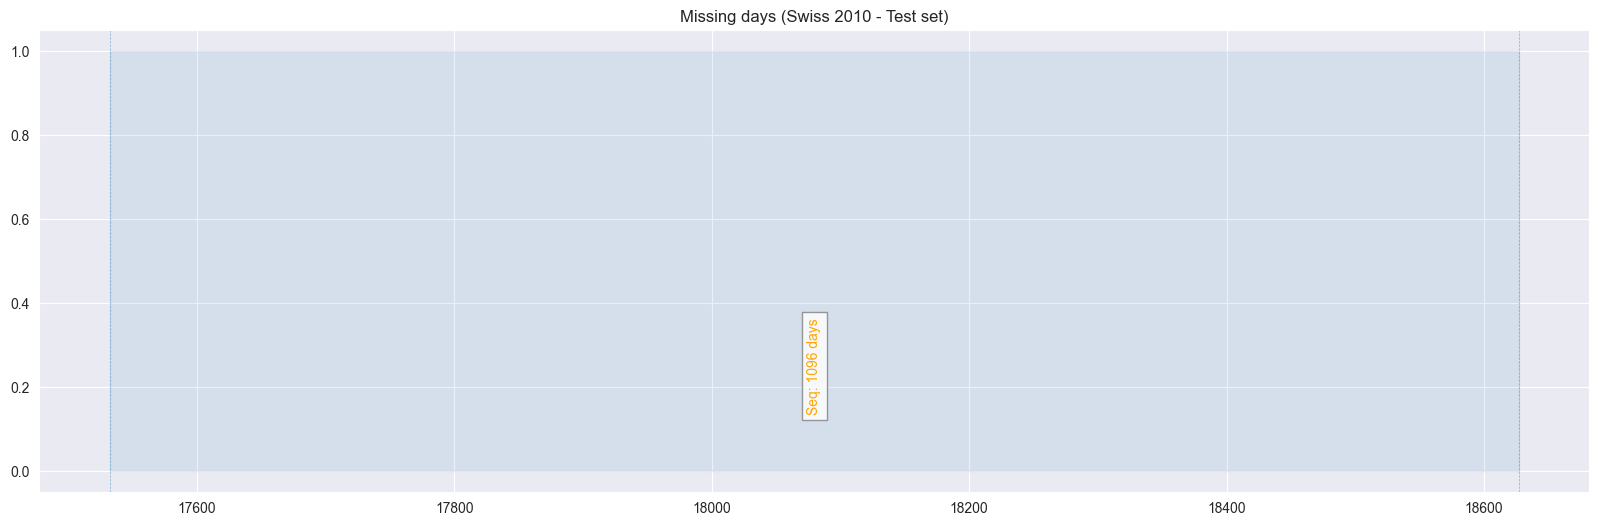

[issue] # of days with missing temperatures per station: {'2033': 365, '2091': 365, '2143': 365, '2170': 365, '2174': 365, '2179': 7, '2232': 365, '2276': 4, '2282': 365, '2288': 365, '2347': 31, '2410': 365, '2432': 2, '2467': 1, '2609': 367, '2612': 731, '2617': 731, '2634': 365, '2635': 1}


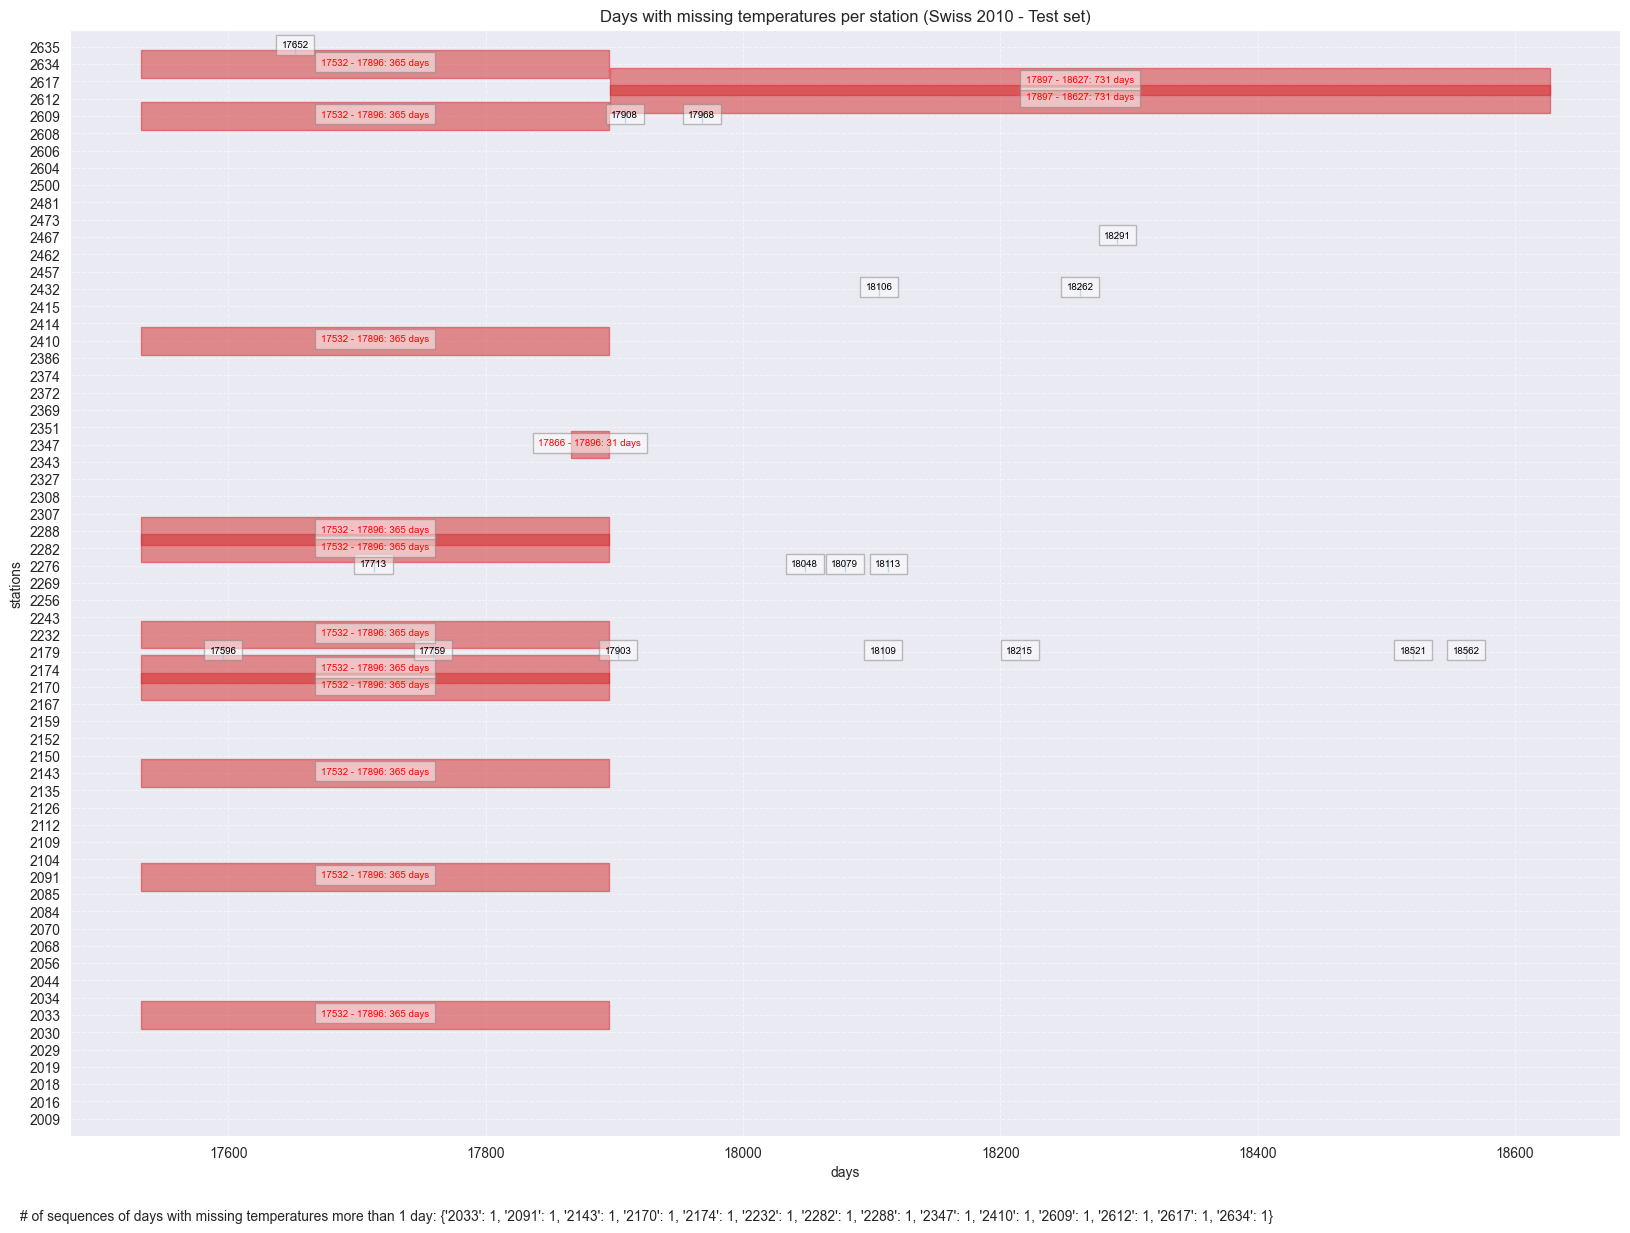

[issue] # of sequences of days with missing temperatures per station (more than 1 day): {'2033': 1, '2091': 1, '2143': 1, '2170': 1, '2174': 1, '2232': 1, '2282': 1, '2288': 1, '2347': 1, '2410': 1, '2609': 1, '2612': 1, '2617': 1, '2634': 1}
~~~ Zurich ~~~ 
[info] Stations: 15
['534', '570', '597', '533', '523', '517', '520', '531', '554', '527', '522', '572', '586', '548', '552']
[info] Training Samples: 4017.
[info] min day: 14245, max day: 18261.
[issue] Gaps: []


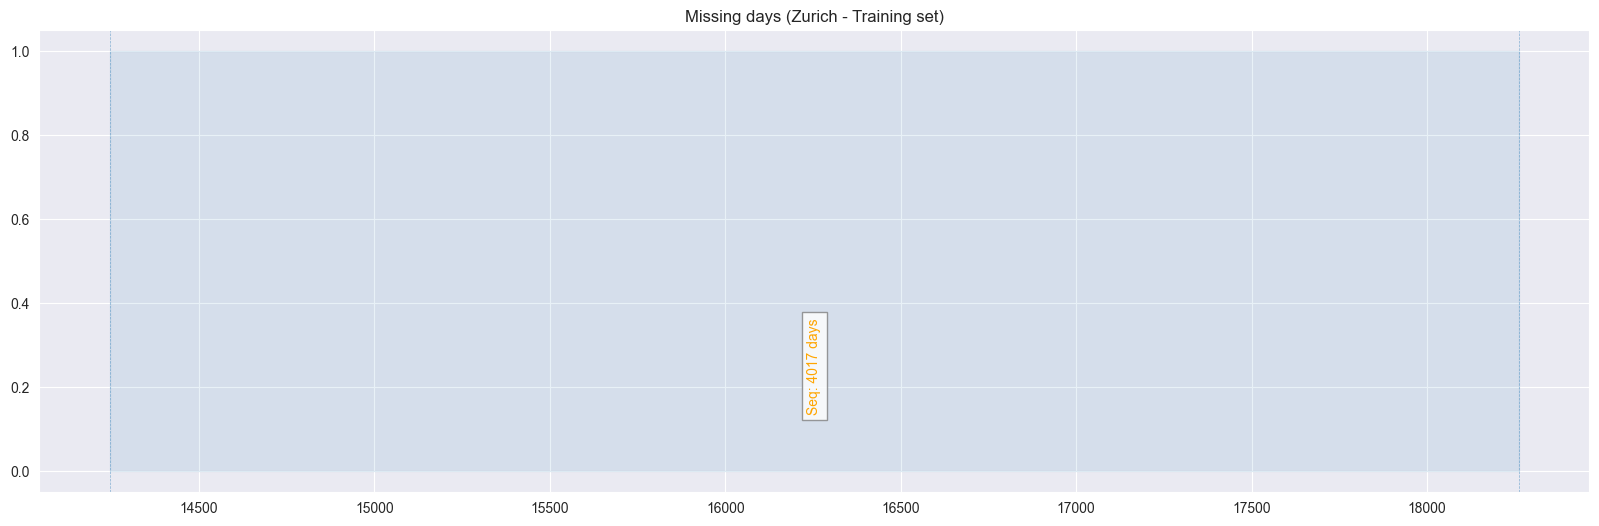

[issue] # of days with missing temperatures per station: {'586': 581}


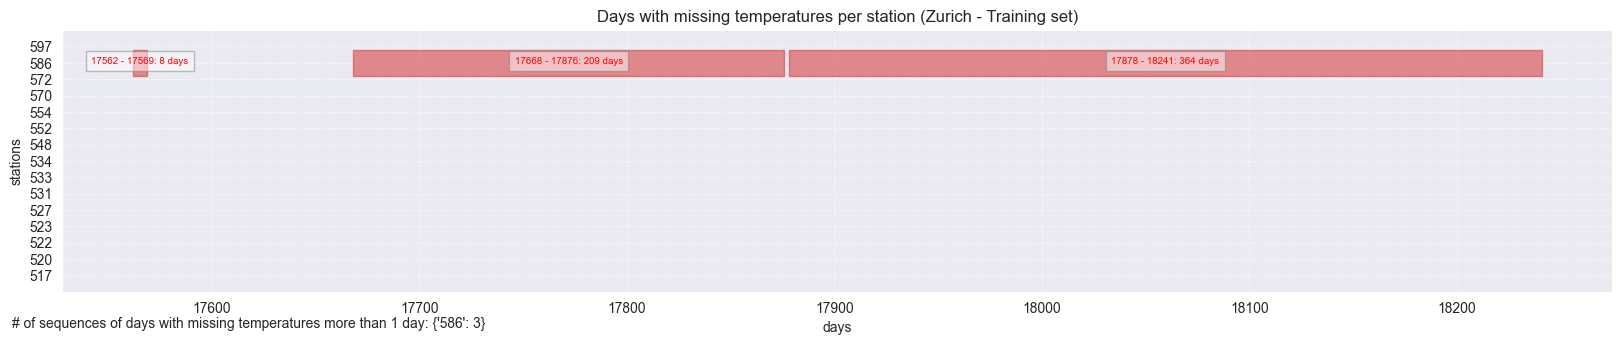

[issue] # of sequences of days with missing temperatures per station (more than 1 day): {'586': 3}

[info] Test Samples: 1035.
[info] min day: 18262, max day: 19296.
[issue] Test Gaps: []


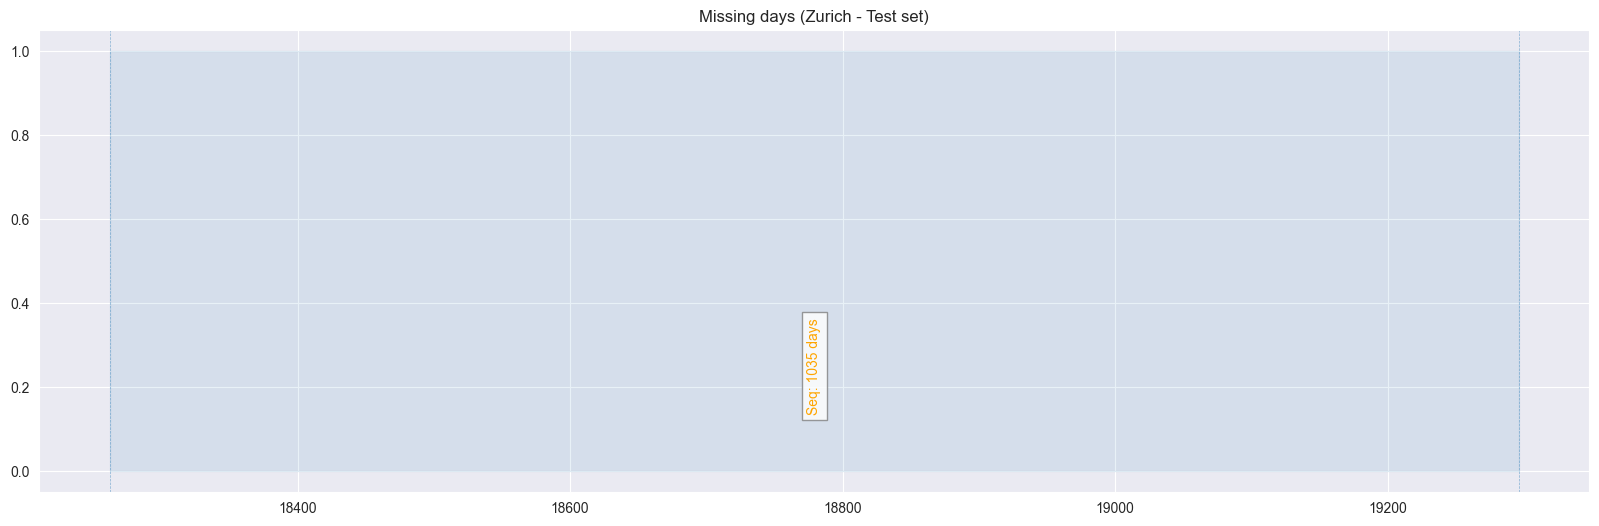

[issue] # of days with missing temperatures per station: {'597': 156}


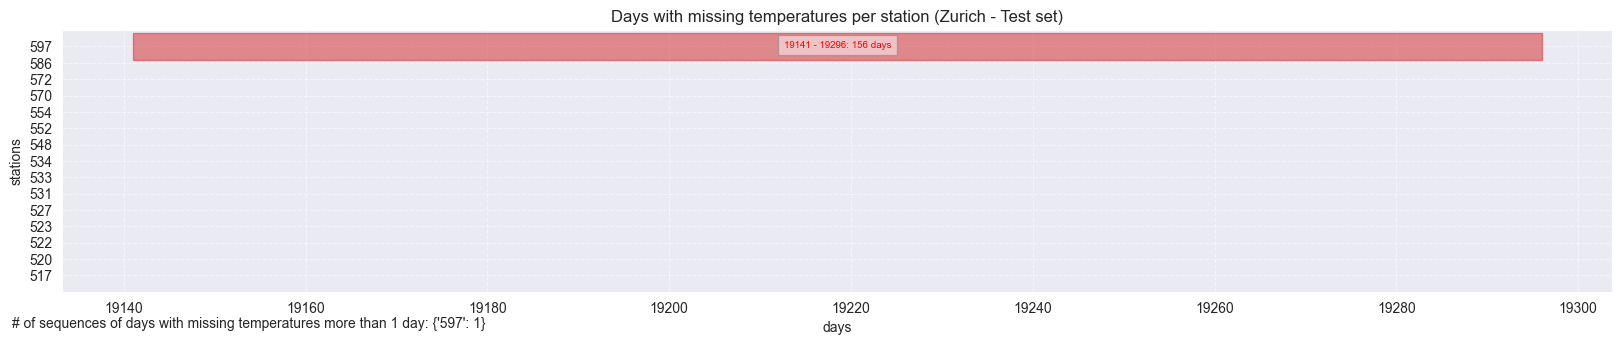

[issue] # of sequences of days with missing temperatures per station (more than 1 day): {'597': 1}


In [12]:
import time

for graph_name in GRAPH_NAMES[0:]:  # debug only
    print(f'~~~ {label[graph_name]} ~~~ ')

    stations = read_stations(graph_name, base_dir=PROJ_DIR)
    print(f'{INFO_TAG}Stations: {len(stations)}')
    print(stations)

    df = read_csv_train(graph_name, base_dir=PROJ_DIR)
    print(f'{INFO_TAG}Training Samples: {len(df)}.')
    print(f'{INFO_TAG}min day: {df["epoch_day"].min()}, max day: {df["epoch_day"].max()}.')
    # print(df)
    days = np.sort(df['epoch_day'].unique())
    gaps = days[1:] - days[:-1]
    print(f'{ISSUE_TAG}Gaps: {gaps[gaps > 1]}')
    # Plot day gaps:
    plot_gaps(days, title=f'Missing days ({label[graph_name]} - Training set)')

    missing_days = get_missing_temperature_days(df, stations)
    plot_missing_temperature_days(missing_days, title=f'Days with missing temperatures per station ({label[graph_name]} - Training set)')

    time.sleep(0.01)

    print()
    df_test = read_csv_test(graph_name, base_dir=PROJ_DIR)
    print(f'{INFO_TAG}Test Samples: {len(df_test)}.')
    print(f'{INFO_TAG}min day: {df_test["epoch_day"].min()}, max day: {df_test["epoch_day"].max()}.')
    # print(df_test)
    days_test = np.sort(df_test['epoch_day'].unique())
    gaps_test = days_test[1:] - days_test[:-1]
    print(f'{ISSUE_TAG}Test Gaps: {gaps_test[gaps_test > 1]}')
    plot_gaps(days_test, title=f'Missing days ({label[graph_name]} - Test set)')

    missing_days_test = get_missing_temperature_days(df_test, stations)
    plot_missing_temperature_days(missing_days_test, title=f'Days with missing temperatures per station ({label[graph_name]} - Test set)')

    time.sleep(0.01)


**All missing temperatures are for water. All air temperatures are present.**